In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import ternary
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from cmcrameri import cm
import ScientificColourMaps8 as SCM8
from scipy.stats import norm
from scipy.interpolate import interp1d
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import ttest_ind, norm
from math import pi
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
from Ti_dynamo_code import *

# Figure 1 

We can use the method `plot_int_vs_time()` within class `DynamoGenerate` to investigate how a range of parameters impact the output of the model.  <br>

You must define a range of values you would like to sweep over for $D_{max}$, $D_{size}$, $t_{Off}$, `method` and $t_{On}$. $D_{max}$ defines the maximum number of diapirs that can be dropped simultaneously, and can have any value. $D_{size}$ defines the distribution of diapir sizes and can range from 1 - 40, where low values will create a uniform diapir distribution, and high values will create a bias toward smaller diapirs. $t_{Off}$ sets the maximum duration of the periods of cessation during the intermittent dynamo history in ka. `method` defines the way in which melting is handled and can be set as 'height' (Scenario 1), 'volume' (Scenario 2) or 'independent' (Scenario 3), which we use in this case. If 'height' or 'volume' are selected then the melting constant $c$ must be defined.  In this case, where 'independent' is used, we must instead define the maximum duration of melting, $t_{On}$ in ka.    <br>

To output properties of the dynamo record for plotting, use the method `dynamo_loop_properties` which will tell you:  <br>
`percent_on_array` the percentage of time the dynamo was active for, <br>
`total_on_array` the total duration of intermittent dynamo activity, <br>
`av_B_array` the average surface field when the dynamo was active, <br>
`max_B_array` the maximum surface field when the dynamo was active, <br>
`min_B_array` the minimum field when then dynamo was active, <br>
`av_melt_array` the average melting time of diapirs, <br>
`tOff_av_array` the average duration of off periods between periods of dynamo activity, <br>
`av_vol_array` and the average volume of Ti-rich cumulates dropped in a single time step. <br>

**N.B. This will not look exactly the same as the published figure since the model is stochastic!**

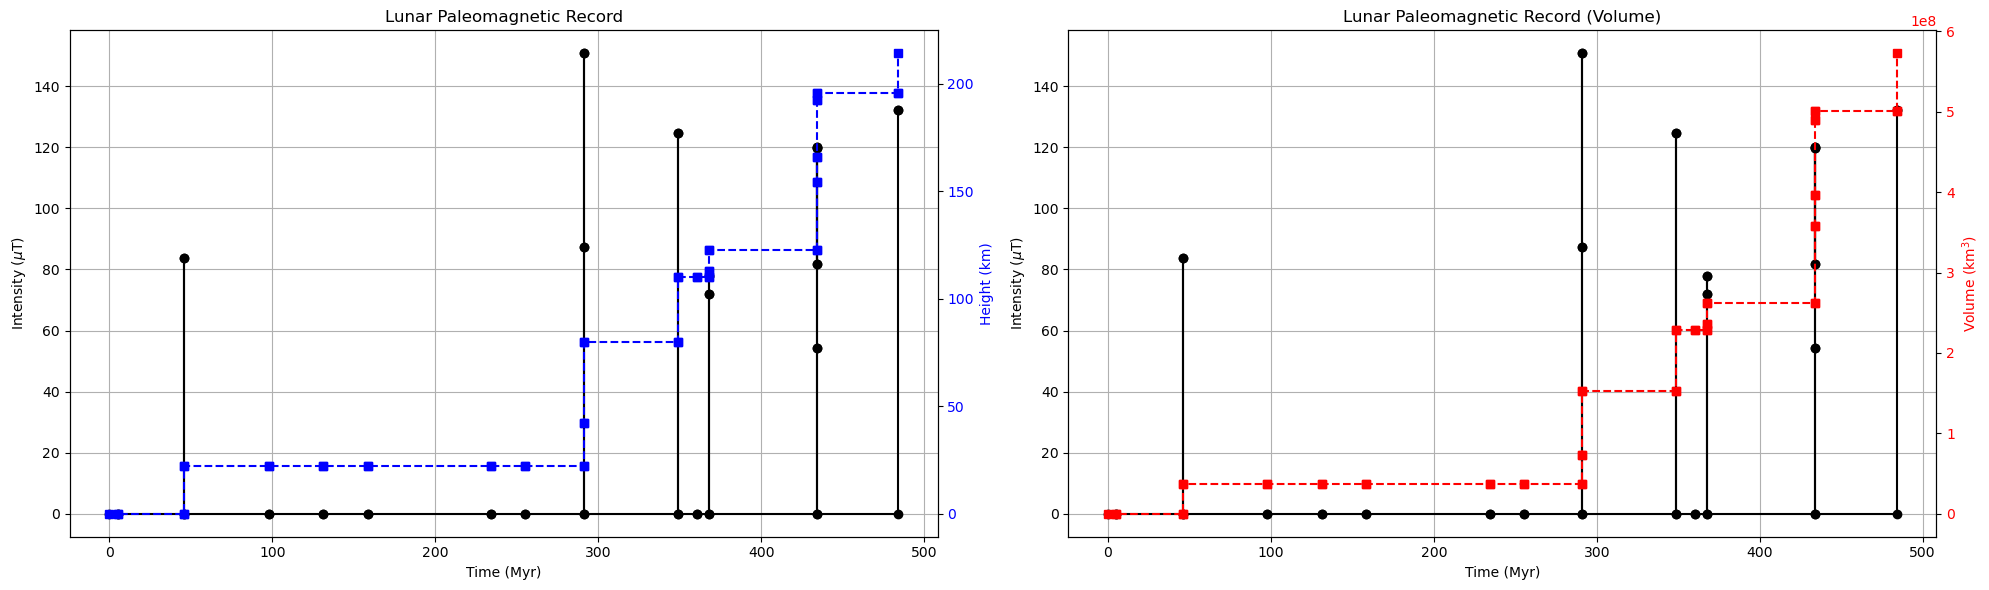

In [3]:
dynamo = DynamoGenerate(1800, 1, 85000, 'independent',tOn = 0.0045)
dynamo.plot_int_vs_time()

# Figure 2

To load in the pre-processed data, run the following commands:

In [4]:
# Load the data
properties_df = pd.read_csv("Independent_loop_output.csv")
parameters_df = pd.read_csv("Independent_loop_parameters.csv")

If you want to generate the results yourself, use the following code. Note that this takes several hours to run.

```
method = 'independent'
maxD_values = np.logspace(1,4,10)
tOff_values = np.logspace(2,4,10)
tOn_values = np.logspace(-4,1,20)
sdD_values = np.linspace(1,40,5)

properties_list = dynamo.loop_dynamo(
    method,
    maxD_values, 
    tOff_values, 
    sdD_values,
    tOn_values = tOn_values,
    save_output = True,
    outfile_name = "Independent_loop_output.csv"
)

parameters_list = dynamo.loop_dynamo_parameters(
    method,
    maxD_values, 
    tOff_values, 
    sdD_values,
    tOn_values = tOn_values,
    save_output = True,
    outfile_name = "Independent_loop_parameters.csv"
)
```

To generate the ternary diagram shown in Figure 2, run the following code which saves the output as "ternary_dynamo_melt.svg".

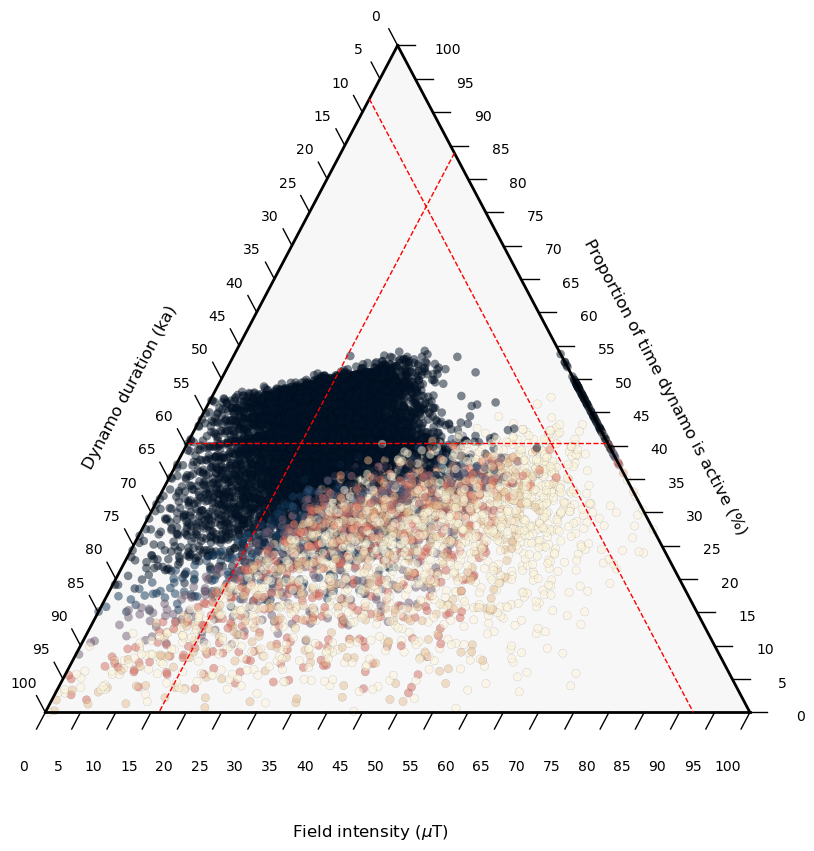

In [5]:
scale = 100
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10, 10)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
#tax.gridlines(color="black", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.left_axis_label("Dynamo duration (ka)", fontsize=fontsize, offset=offset)
tax.right_axis_label("Proportion of time dynamo is active (%)", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Field intensity ($\mu$T)", fontsize=fontsize, offset=offset)

# Data converted to a log scale
# Dynamo duration
A1 = np.log10(properties_df['total_on'])
A2 = 100 * (A1 - np.min(A1)) / (np.max(A1) - np.min(A1))
A = 100 - A2
#Duration limit
Aline1 = np.log10(0.664e6)
Aline2 = 100 * (Aline1 - np.min(A1)) / (np.max(A1) - np.min(A1))
Aline = 100 - Aline2

# Field strength
B1 = np.log10(properties_df['max_B'])
B = 100 * (B1 - np.min(B1)) / (np.max(B1) - np.min(B1))
#Field strength limit
Bline1 = np.log10(53)
Bline = 100 * (Bline1 - np.min(B1)) / (np.max(B1) - np.min(B1))

# Percent on 
C1 = np.log10(properties_df['percent_on'])
C2 = 100 * (C1 - np.min(C1)) / (np.max(C1) - np.min(C1))
C = 100 - C2
#Percent on limit
Cline1 = np.log10(26)
Cline2 = 100 * (Cline1 - np.min(C1)) / (np.max(C1) - np.min(C1))
Cline = 100 - Cline2

# Melting time
D = np.log10(properties_df['av_melt'])

# Normalize the data so that A + B + C = 40 for each point
sum_ABC = A + B + C
A_normalized = A / sum_ABC * 100
B_normalized = B / sum_ABC * 100
C_normalized = C / sum_ABC * 100

# Create points for plotting
points = list(zip(A_normalized, B_normalized, C_normalized))

# Scatter plot with outlines
scatter = tax.scatter(points, 
                      marker='o',
                      c=D, 
                      cmap=SCM8.lipari, 
                      edgecolors='black',  
                      linewidths=0.1,
                      alpha=0.5
                     )



# Draw lines parallel to the axes
tax.horizontal_line(Bline, linewidth=1., color='red', linestyle="--")
tax.left_parallel_line(Aline, linewidth=1., color='red', linestyle="--")
tax.right_parallel_line(Cline, linewidth=1., color='red', linestyle="--")

tax.ticks(axis='lbr', multiple=5, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()

#show the plot
tax.show()


# Figure 3

Many aspects of Figure 3 were made using `Igor Pro` from `Wavemetrics` and final formatting was conducted in `Inkscape`. The data shown in the figures and analysis for Figure 3b `Python` are shown below.

# Figure 3a

First, load the data the modern paleointensity record (all studies since 2008 - see Supplementary Table S1 for details), and lunar basalt compositional data published by Kato et al., *MAPS* (2017).

In [6]:
#Load the paleointensity record data
pint_record_df = pd.read_csv("paleointensity_record.csv")
#Load basalt compositional data from Kato et al 2017
basalt_df = pd.read_csv("basalt_TiO_Kato2017.csv")

We can no create scatter plot that shows paleointensity vs age for the paleomagnetic record, with each point colour coded by lithology.  On the right hand axis, we also show the composition of all erupted basalts throughout the lunar history.

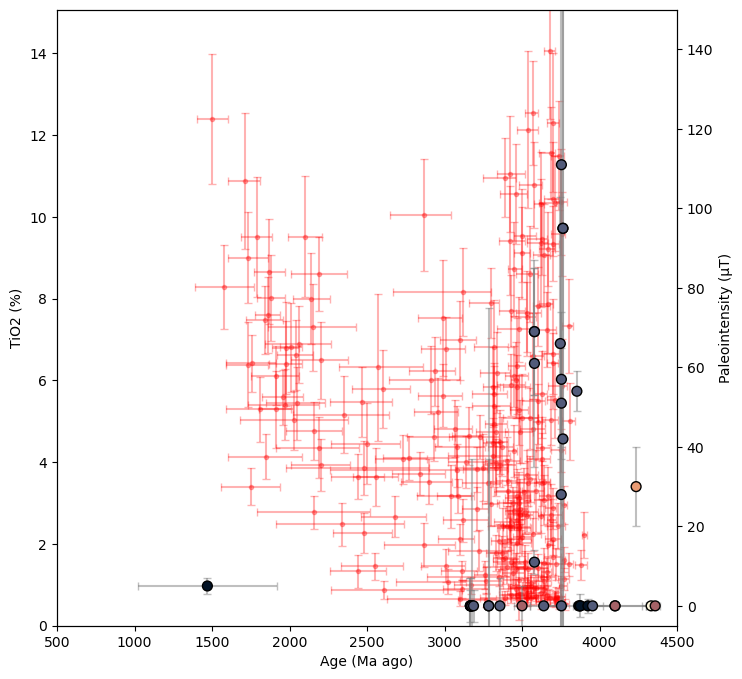

In [7]:
# Paleointensity data
Pint_values = pint_record_df['Pint']  # y-axis data
PintSD_values = pint_record_df['PintSD']  # vertical error bars (standard deviations)
Age_values = pint_record_df['Age'] # x-axis data
AgeSD_values = pint_record_df['AgeSD'] # horizontal error bars (standard deviations)
Lith_values = pint_record_df['LithCode'] # lithology type

# Convert the columns to numeric
basalt_df['Age'] = pd.to_numeric(basalt_df['Age'], errors='coerce')
basalt_df['AgePlus'] = pd.to_numeric(basalt_df['AgePlus'], errors='coerce')
basalt_df['AgeMinus'] = pd.to_numeric(basalt_df['AgeMinus'], errors='coerce')
basalt_df['TiO2'] = pd.to_numeric(basalt_df['TiO2'], errors='coerce')
basalt_df['TiO2SD'] = pd.to_numeric(basalt_df['TiO2SD'], errors='coerce')

# Convert Ga to Ma (if needed)
age_kato = 1000 * basalt_df['Age']  # Convert Ga to Ma
age_plus_kato = 1000 * basalt_df['AgePlus']
age_minus_kato = 1000 * basalt_df['AgeMinus']
TiO_kato = basalt_df['TiO2']
TiO_SD_kato = basalt_df['TiO2SD']

# Calculate the asymmetric error bars for the x-axis
age_err_kato = [age_minus_kato, age_plus_kato]

# Create a square figure with two subplots
fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot the Kato et al., 2017 data on the primary y-axis (TiO2 vs Age)
# This is done first to ensure it's plotted beneath the primary dataset
ax1.errorbar(age_kato, 
             TiO_kato, 
             xerr=age_err_kato, 
             yerr=TiO_SD_kato, 
             fmt='.', 
             color='red', 
             label='Kato et al., 2017',
             alpha=0.3,
             capsize=3, 
             zorder=1)  # Lower zorder to ensure it is beneath

# Create a second y-axis for Paleointensity
ax2 = ax1.twinx()

# Plot the paleointensity dataset on the secondary y-axis
ax2.errorbar(Age_values, 
             Pint_values, 
             xerr=AgeSD_values, 
             yerr=PintSD_values, 
             fmt='none', 
             ecolor='gray', 
             capsize=3, 
             alpha=0.5, 
             zorder=2)

scatter = ax2.scatter(Age_values, 
                      Pint_values, 
                      s=50, 
                      c=Lith_values, 
                      cmap=SCM8.lipari, 
                      edgecolors='black', 
                      alpha=1, 
                      zorder=3)  # Higher zorder to ensure it is on top

# Set limits and labels
ax1.set_xlim(500, 4500)
ax1.set_ylim(0, max(TiO_kato) + 1)  # Adjust this as necessary for TiO2

ax2.set_ylim(-5, 150)
ax2.set_ylabel('Paleointensity (µT)')

ax1.set_ylabel('TiO2 (%)')
ax1.set_xlabel('Age (Ma ago)')

# Show the plot
plt.show()


# Figure 3b

In this figure, we will plot all the data for lunar basalts that have had a paleointensity measured eiher as a lower limit, or with constrained error bars (i.e., we omit values where the uncertainty is unconstrained).  We compare paleointensity to TiO2 content, and carry out statistical analyses to determine whether there is a relationship between the two.

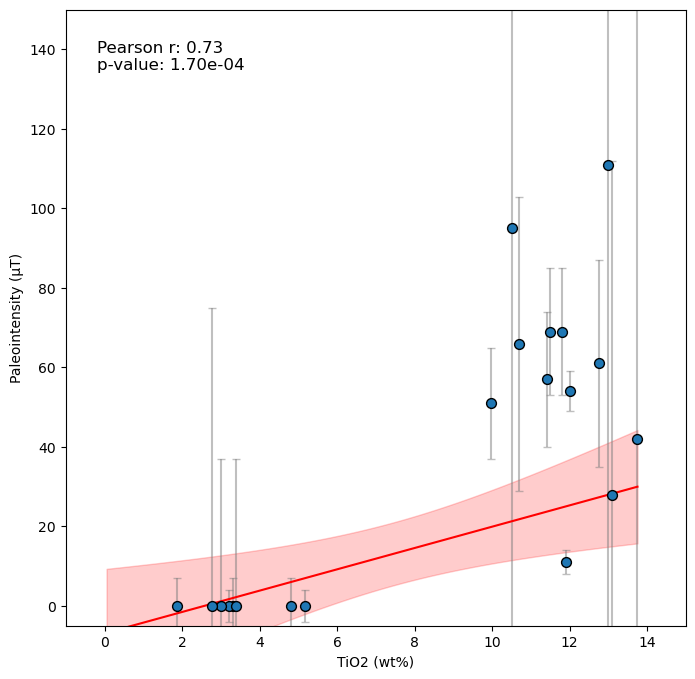

In [8]:
# Load weighted regression data
weighted_df = pd.read_csv("weighted_regression_pint_vs_Ti_content.csv")

# Extract data
weighted_TiO = weighted_df['TiO']
weighted_pint = weighted_df['paleointensity']
sample_weight = weighted_df['weighting']

# Add a constant to the independent variable matrix
TiO_with_const = sm.add_constant(weighted_TiO)

# Fit the weighted linear regression model using statsmodels
model = sm.WLS(weighted_pint, TiO_with_const, weights=sample_weight).fit()

# Create a range of values for TiO to plot the regression line
TiO_range = np.linspace(weighted_TiO.min(), weighted_TiO.max(), 100)
TiO_range_with_const = sm.add_constant(TiO_range)

# Get predictions and confidence intervals
predictions = model.get_prediction(TiO_range_with_const)
pred_summary_frame = predictions.summary_frame()

# Extract the mean prediction and the confidence intervals
y_pred = pred_summary_frame['mean']
ci_lower = pred_summary_frame['mean_ci_lower']
ci_upper = pred_summary_frame['mean_ci_upper']

# Calculate Pearson's r and p-value using the actual data
r, p_value = pearsonr(weighted_TiO, weighted_pint)

# Filter the data to only consider basalts, and paleointensity with associated uncertainty
filtered_df = pint_record_df[(pint_record_df['LithCode'] == 2) & (pint_record_df['PintSD'] != 0)]

# Extract the filtered values
TiO_values = filtered_df['TiO2']  # x-axis data
Pint_values = filtered_df['Pint']  # y-axis data
PintSD_values = filtered_df['PintSD']  # vertical error bars (standard deviations)

# Create a figure and an axis
fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot the error bars for the filtered paleointensity dataset
ax1.errorbar(TiO_values, 
             Pint_values, 
             yerr=PintSD_values, 
             fmt='none', 
             ecolor='gray', 
             capsize=3, 
             alpha=0.5, 
             zorder=2)

# Plot the scatter points on top of the error bars
scatter = ax1.scatter(TiO_values, 
                      Pint_values, 
                      s=50,  
                      edgecolors='black', 
                      alpha=1, 
                      zorder=3)  # Highest zorder to ensure it is on top

# Plot the weighted regression line with confidence intervals
ax1.plot(TiO_range, y_pred, color='red', label='Weighted Regression Line')
ax1.fill_between(TiO_range, ci_lower, ci_upper, color='red', alpha=0.2, label='95% CI')

# Set limits and labels
ax1.set_xlim(-1, 15)
ax1.set_ylim(-5, 150)

ax1.set_ylabel('Paleointensity (µT)')
ax1.set_xlabel('TiO2 (wt%)')

# Annotate the plot with the Pearson's r value and p-value
ax1.annotate(f'Pearson r: {r:.2f}\np-value: {p_value:.2e}', xy=(0.05, 0.95), xycoords='axes fraction', 
            fontsize=12, verticalalignment='top')

# Show the plot
plt.show()

We will now consider the weighted mean paleointensities for low Ti basalts (See Table S2). For each paleointensity, we draw a population of 10,000 points from the mean and standard deviation.

In [9]:
df_low = pd.read_csv("low_Ti_pint.csv")

def sample_normal_non_negative(mean, std_dev, size):
    samples = []
    while len(samples) < size:
        new_samples = np.random.normal(loc=mean, scale=std_dev, size=size - len(samples))
        new_samples = new_samples[new_samples >= 0]
        samples.extend(new_samples)
        if len(samples) >= size:
            break
    return samples

# Define the ranges for mean and standard deviation
means = df_low['pint']  # Example means
std_devs = df_low['pintSD']# Example standard deviations
TiO = df_low['TiO']
sample_size = 10000  # Number of samples per combination

# Create a list of (mean, std_dev) tuples
combinations = [(mean, std_dev) for mean in means for std_dev in std_devs]

# Initialize a list to store results
results_list = []
Ti_list_low = []

# Loop through each combination of mean and standard deviation
for x in range (0,8):
    # Generate samples for the current mean and std_dev
    samples = sample_normal_non_negative(means[x], std_devs[x], sample_size)
    
    # Append the result to the list
    results_list.append(samples)
    
    for y in range (0,sample_size):
        Ti_list_low.append(TiO[x])

results_list_low = [item for sublist in results_list for item in sublist]
    


We will now consider the weighted mean paleointensities for high Ti basalts (See Table S3). For each paleointensity, we draw a population of 10,000 points from the mean and standard deviation.

In [10]:
df_high = pd.read_csv("high_Ti_pint.csv")

def sample_normal_non_negative(mean, std_dev, size):
    samples = []
    while len(samples) < size:
        new_samples = np.random.normal(loc=mean, scale=std_dev, size=size - len(samples))
        new_samples = new_samples[new_samples >= 0]
        samples.extend(new_samples)
        if len(samples) >= size:
            break
    return samples

# Define the ranges for mean and standard deviation
means = df_high['pint']  # Example means
std_devs = df_high['pintSD']# Example standard deviations
TiO = df_high['TiO']
sample_size = 10000  # Number of samples per combination

# Create a list of (mean, std_dev) tuples
combinations = [(mean, std_dev) for mean in means for std_dev in std_devs]

# Initialize a list to store results
results_list = []
Ti_list_high = []

# Loop through each combination of mean and standard deviation
for x in range (0,12):
    # Generate samples for the current mean and std_dev
    samples = sample_normal_non_negative(means[x], std_devs[x], sample_size)
    
    # Append the result to the list
    results_list.append(samples)
    
    for y in range (0,sample_size):
        Ti_list_high.append(TiO[x])

results_list_high = [item for sublist in results_list for item in sublist]

These populations are used to generate the histograms shown on the right hand side of Figure 3b

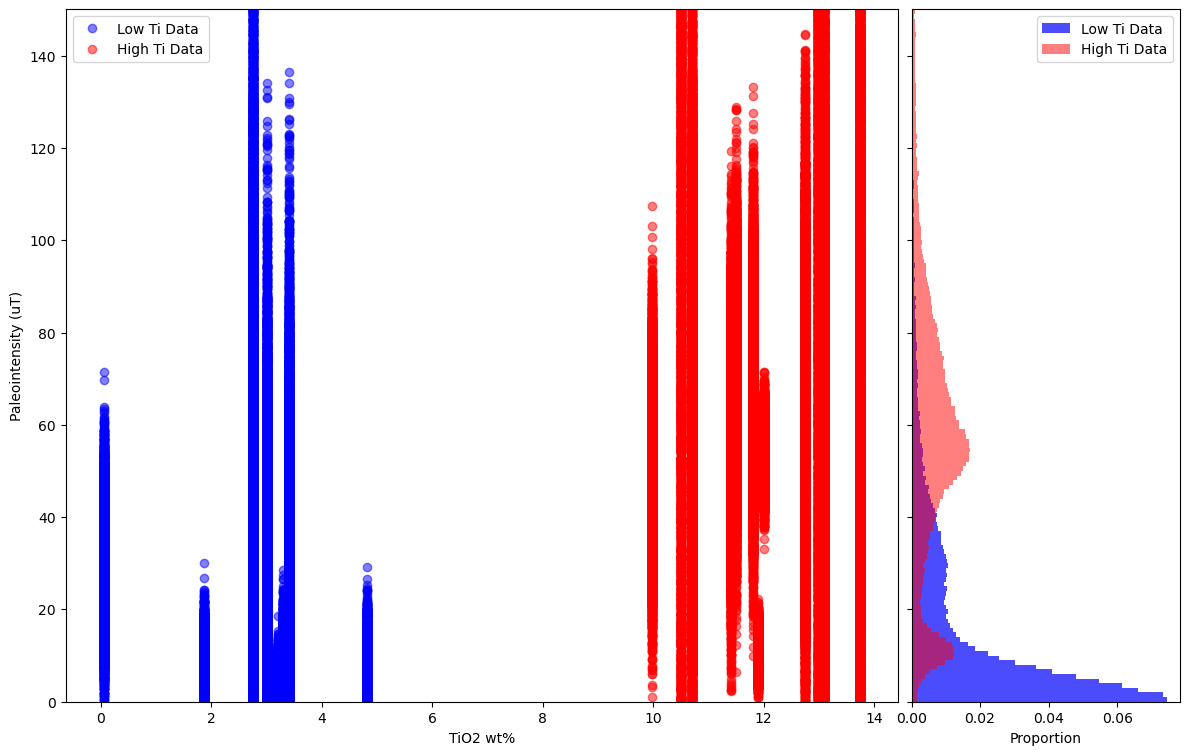

In [11]:
# Combine results for plotting
x_low = Ti_list_low
y_low = results_list_low

x_high = Ti_list_high
y_high = results_list_high

# Calculate uncertainties (standard deviation is often a good choice for error bars)
x_err_low = np.zeros_like(x_low)  # Assuming no error for x values
y_err_low = np.std(results_list_low) * np.ones_like(y_low)  # Error for y values

x_err_high = np.zeros_like(x_high)  # Assuming no error for x values
y_err_high = np.std(results_list_high) * np.ones_like(y_high)  # Error for y values

# Create a GridSpec layout
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(4, 4, figure=fig)

# Create scatter plot
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_scatter.plot(x_low, 
                y_low, 
                'o', 
                alpha=0.5, 
                color='blue', 
                label='Low Ti Data')
ax_scatter.plot(x_high, 
                y_high, 
                'o', 
                alpha=0.5, 
                color='red', 
                label='High Ti Data')
ax_scatter.set_xlabel('TiO2 wt%')
ax_scatter.set_ylabel('Paleointensity (uT)')
ax_scatter.set_ylim(0, 150)  # Set the y-axis limits
ax_scatter.legend()

# Define bin edges with a width of 10
bin_width = 1
bins_y_low = np.arange(min(y_low), max(y_low) + bin_width, bin_width)
bins_y_high = np.arange(min(y_high), max(y_high) + bin_width, bin_width)

# Calculate histograms
counts_y_low, edges_y_low = np.histogram(y_low, bins=bins_y_low)
counts_y_high, edges_y_high = np.histogram(y_high, bins=bins_y_high)

# Normalize histograms to get proportions
counts_y_low = counts_y_low / np.sum(counts_y_low)
counts_y_high = counts_y_high / np.sum(counts_y_high)

# Calculate bin centers
bin_centers_y_low = (edges_y_low[:-1] + edges_y_low[1:]) / 2
bin_centers_y_high = (edges_y_high[:-1] + edges_y_high[1:]) / 2

# Create histogram on the right (y-axis histogram) without error bars
ax_hist_y = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)
ax_hist_y.barh(bin_centers_y_low, 
               counts_y_low, 
               height=bin_width, 
               color='blue', 
               alpha=0.7, 
               align='center', 
               label='Low Ti Data')
ax_hist_y.barh(bin_centers_y_high, 
               counts_y_high, 
               height=bin_width, 
               color='red', 
               alpha=0.5, 
               align='center', 
               label='High Ti Data')
ax_hist_y.set_xlabel('Proportion')
plt.setp(ax_hist_y.get_yticklabels(), visible=False)
ax_hist_y.legend()

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)  # Adjust space between plots

# Show the plot
plt.show()

Finally, we conduct a T-test using the weighted mean and variance on the paleointensity for both low and high-Ti basalts (see Tables S2 and S3).  We use a log-normal distribution so that paleointensities cannot be negative, which is unrealistic.

In [12]:
# Weighted mean and variance of paleointensity for both basalt populations
sample1 = np.array([1.52, 6.97, 9]) #low Ti basalts
sample2 = np.array([26.64, 22.72, 12]) #High Ti basalts

# Function to convert mean and variance of a normal distribution to parameters of a log-normal distribution
def normal_to_lognormal_params(mean, variance):
    phi = np.sqrt(variance + mean**2)
    mu = np.log(mean**2 / phi)
    sigma = np.sqrt(np.log(phi**2 / mean**2))
    return mu, sigma

# Convert sample means and variances to log-normal parameters
mu1, sigma1 = normal_to_lognormal_params(sample1[0], sample1[1])
mu2, sigma2 = normal_to_lognormal_params(sample2[0], sample2[1])

# Generate random samples based on the log-normal distribution
np.random.seed(0)  # For reproducibility
data1 = np.random.lognormal(mean=mu1, sigma=sigma1, size=int(sample1[2]))
data2 = np.random.lognormal(mean=mu2, sigma=sigma2, size=int(sample2[2]))

# Perform the t-test on the log-transformed data
log_data1 = np.log(data1)
log_data2 = np.log(data2)
t_stat, p_value = ttest_ind(log_data1, log_data2, equal_var = False, alternative = 'less')
print(f't-statistic: {t_stat:.3f}, p-value: {p_value:.3f}')


t-statistic: -6.241, p-value: 0.000


# Figure 3c

Load the timing of lunar volcanism events collated and re-assessed with high-quality U-Pb geochronology by Snape et al., 2019

In [13]:
#Load the paleointensity record data
volcanism_df = pd.read_csv("lunar_volcanism_Snape2019.csv")

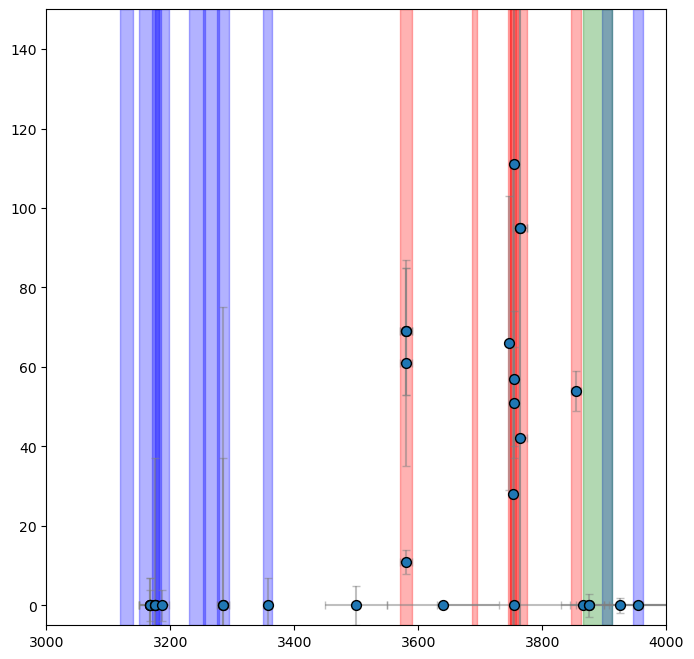

In [14]:
# Example volcanism data
volcanism_age = volcanism_df['Age']  # ages
volcanism_age_SD = volcanism_df['AgeSD']  # age standard deviations
volcanism_type = volcanism_df['Type']  # type variable (string)

# Define a color mapping for each type
color_mapping = {
    'highTi': 'red',
    'lowTi': 'blue',
    'KREEP': 'green',
}

# Paleointensity data
TiO_values = pint_record_df['TiO2']  # x-axis data
Pint_values = pint_record_df['Pint']  # y-axis data
PintSD_values = pint_record_df['PintSD']  # vertical error bars (standard deviations)
Age_values = pint_record_df['Age']
AgeSD_values = pint_record_df['AgeSD']

# Create a figure and an axis
fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot the shaded boxes for the volcanism data
for age, ageSD, vtype in zip(volcanism_age, volcanism_age_SD, volcanism_type):
    color = color_mapping.get(vtype, 'gray')  # Default to gray if type is not in the mapping
    ax1.axvspan(age - ageSD, age + ageSD, color=color, alpha=0.3, zorder=1)

# Plot the error bars for the paleointensity dataset
ax1.errorbar(Age_values, 
             Pint_values, 
             xerr=AgeSD_values, 
             yerr=PintSD_values, 
             fmt='none', 
             ecolor='gray', 
             capsize=3, 
             alpha=0.5, 
             zorder=2)

# Plot the scatter points on top of the error bars
scatter = ax1.scatter(Age_values, 
                      Pint_values, 
                      s=50,  
                      edgecolors='black', 
                      alpha=1, 
                      zorder=3)  # Highest zorder to ensure it is on top

# Set limits and labels
ax1.set_xlim(3000, 4000)
ax1.set_ylim(-5, 150)  

# Show the plot
plt.show()
